# Exercise 4

## Inhalt des Notebooks
Im vorliegenden Notebook wird der Datensatz Credit analysiert. Zunächst wird dieser exploriert und vorverarbeitet. Folgend werden lineare Regressionen (OLS) mit verschiedenen exogenen Variablen durchgeführt und die Ergebnisse anhand des RMSE verglichen. Dabei werden auch die Koeffizienten und insbesondere deren Werte und Signifikanzen untersucht. Des Weiteren wird der Random Forest für eine Auswahl von exogenen Variablen verwendet und dessen Ergebnisse anhand von RMSE verglichen. Außerdem wird die Feature Importance der Variablen beim Random Forest untersucht. Das Kernergebnis der Regressionen und Random Forests ist, dass Multikollinearität wenig Einfluss auf die Prognosekraft der Modelle besitzt, jedoch der Einfluss der Variablen bei Multikollinearität kaum isolierbar ist. Zudem ist bei den Regressionen zu erkennen, dass die Koeffizienten bei vorliegender Multikollinearität sehr unpräzise geschätzt werden, was an tendenziell breiten Konfidenzintervallen zu erkennen ist.

## Bibliotheken und Einstellungen

In [1]:
# import libraries 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display
import seaborn as sns

## Teilaufgaben

### a) Daten einlesen und erkunden
Lesen Sie den Datensatz Credit.csv ein. Erkunden Sie die Daten und konvertieren Sie gegebenenfalls kategorische Variablen in ein geeignetes Format (z.B. mit pandas.get_dummies() oder sklearn.model_selection.OneHotEncoder()). 

In [2]:
# load dataset
data_raw = pd.read_csv('./data/Credit.csv')

# first insight of data by checking the first 5 data samples
data_raw.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [3]:
print('Information about data type: ')
print(data_raw.info())

print('\nInformation about variable Ethnicity:')
data_raw["Ethnicity"].unique()

Information about data type: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Unnamed: 0    400 non-null int64
Income        400 non-null float64
Limit         400 non-null int64
Rating        400 non-null int64
Cards         400 non-null int64
Age           400 non-null int64
Education     400 non-null int64
Gender        400 non-null object
Student       400 non-null object
Married       400 non-null object
Ethnicity     400 non-null object
Balance       400 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 37.6+ KB
None

Information about variable Ethnicity:


array(['Caucasian', 'Asian', 'African American'], dtype=object)

Es gibt 400 Samples und keine fehlende Werte.

Es gibt 10 exogene Variablen: 
- Income (float)
- Limit (integer)
- Rating (integer)
- Cards, (integer)
- Age (integer)
- Education (integer)
- Gender (object/string, dichtomotous)
- Student (object/string, dichtomotous)
- Married (object/string, dichtomotous)
- Ethicity (object/string, categorical with 3 values: Caucasian, Asian, African American)

und eine endogene Variable: 
- Balance (integer).

Die binären Variablen müssen in eine Dummy-Variable mit 1 und 0 bzw. True und False überführt werden. Die kategorische Variable muss in verschiedene Dummy-Variablen entsprechend der Anzahl ihrer Ausprägungen überführt werden (siehe Teilaufgabe c).

Im Folgenden werden die binären Variablen in eine Dummy-Variable überführt zusammen micht den integers und floats in ein Dataframe überführt.

In [7]:
# suppress warning
pd.options.mode.chained_assignment = None

# create dummies of gender
gender_df = pd.get_dummies(data_raw["Gender"])

# select one dummy
is_male = gender_df[["Male"]]

#rename column
is_male.rename(columns = {"Male":"IsMale"}, inplace = True)

In [8]:
# create dummies for student
student = pd.get_dummies(data_raw["Student"])

# select one dummy
is_student = student[["Yes"]]

# rename column
is_student.rename(columns = {"Yes":"IsStudent"}, inplace = True)

In [9]:
# create dummies for married
married = pd.get_dummies(data_raw["Married"])

# select one dummy for married
is_married = married[["Yes"]]

# rename column
is_married.rename(columns = {"Yes":"IsMarried"}, inplace = True)

In [11]:
# create new dataframe
data_without_categorical_binary_variables = data_raw[["Balance","Income", "Limit", "Rating", "Cards", "Age", "Education"]]
data_without_categorical_variables = pd.concat([data_without_categorical_binary_variables, is_married, is_student, is_male], axis=1, join='inner')
data_without_categorical_variables.head()

,Balance,Income,Limit,Rating,Cards,Age,Education,IsMarried,IsStudent,IsMale
0,333,14.891,3606,283,2,34,11,1,0,1
1,903,106.025,6645,483,3,82,15,1,1,0
2,580,104.593,7075,514,4,71,11,0,0,1
3,964,148.924,9504,681,3,36,11,0,0,0
4,331,55.882,4897,357,2,68,16,1,0,1


Im Folgenden werden bereits die Dummies der kategorischen Variablen Ethnicty erstellt und ein geeignetes Dataframe erstellt. Damit wird der Datensplit in b) durchgeführt. Dies ist somit ein Vorzug aus der Teilaufgabe c).

In [12]:
# there are three values for ethnicities: African American, Asian, Caucasian
# convert them into three dummies

ethnicity_raw = pd.Series(data_raw["Ethnicity"], dtype="category") 

# create dummies
african_american = pd.get_dummies(ethnicity_raw == "African American")
asian = pd.get_dummies(ethnicity_raw == "Asian")
caucasian = pd.get_dummies(ethnicity_raw == "Caucasian")

# select one dummy for african_american
is_african_american = african_american[[1]]

# rename column of is_african_american
is_african_american.rename(columns = {True : "IsAfricanAmerican"}, inplace = True)

# select one dummy for asian and caucasian
is_asian = asian[[1]]
is_caucasian = caucasian[[1]]

# rename columns
is_asian.rename(columns = {True : "IsAsian"}, inplace = True)
is_caucasian.rename(columns = {True : "IsCaucasian"}, inplace = True)

In [13]:
# create dataframe with all variables
data = pd.concat([data_without_categorical_variables, is_asian, is_caucasian, is_african_american], axis = 1, join = 'inner')
data.head()

,Balance,Income,Limit,Rating,Cards,Age,Education,IsMarried,IsStudent,IsMale,IsAsian,IsCaucasian,IsAfricanAmerican
0,333,14.891,3606,283,2,34,11,1,0,1,0,1,0
1,903,106.025,6645,483,3,82,15,1,1,0,1,0,0
2,580,104.593,7075,514,4,71,11,0,0,1,1,0,0
3,964,148.924,9504,681,3,36,11,0,0,0,1,0,0
4,331,55.882,4897,357,2,68,16,1,0,1,0,1,0


#### Vertraut werden mit Daten

In [14]:
# print shape of data
data.shape

(400, 13)

Es gibt 400 Samples und 13 Variablen.

In [17]:
# basic statistics of integer and float data
data.iloc[:,:7].describe()

,Balance,Income,Limit,Rating,Cards,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,520.015000,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000
std,459.758877,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207
min,0.000000,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000
25%,68.750000,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000
50%,459.500000,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000
75%,863.000000,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000
max,1999.000000,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000


Zu erkennen sind die unterschiedlichen Wertebereiche der verschiedenen Variablen. Cards hat beispielsweise einen Wertebereich von 1 bis 9 (25%-Quantil: 2, 75%-Quantil: 4), wohingegen Limit einen Wertebereich von 855 bis 13913 (25%-Quantil: 3088, 75%-Quantil: 5872.75) besitzt. Da lineare Regression und Random Forest angewandt wird, ist eine Sklarierung nicht notwendig. Im Folgenden werden die Kennzahlen der vorherigen Variable zur Verdeutlichung anhand von Boxplots visualisiert.

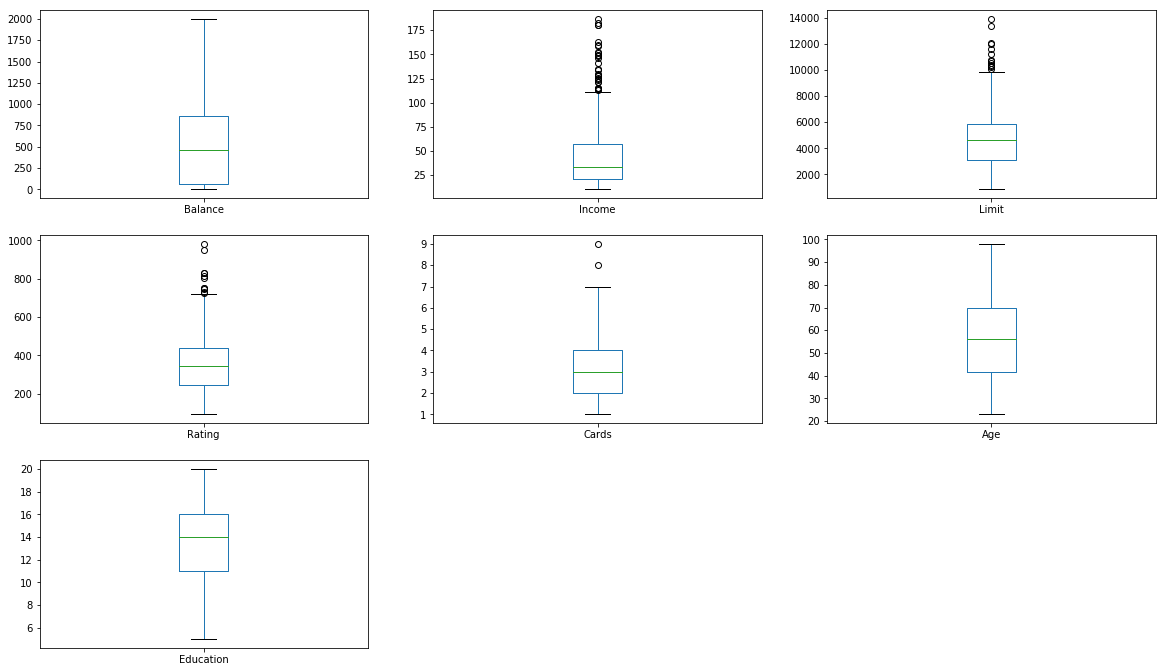

In [18]:
# create boxplot for integer and float data
data.iloc[:, : 7].plot(figsize = (20, 20), kind='box', subplots=True, layout=(5,3), sharex=False, sharey=False);  # show boxplots

Zu erkennen ist, dass Income, Limit und Rating viele Ausreißer nach oben haben. Balance, Age und Education haben eine recht hohe Varianz.

Im Folgenden werden nicht binären Variablen genauer untersucht. Zur Erinnerung: die kategorischen Variablen wurden ihn binäre umgewandelt.

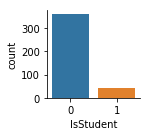

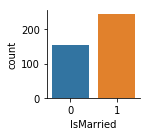

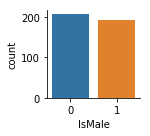

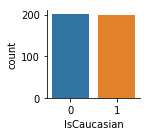

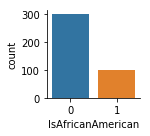

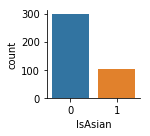

In [64]:
# create binary_data
binary_data = data.iloc[:,7:]

# create figures of binary data
sns.catplot(x="IsStudent", data=binary_data, kind="count", height = 2);
sns.catplot(x="IsMarried", data=binary_data, kind="count", height = 2);
sns.catplot(x="IsMale", data=binary_data, kind="count", height = 2);
sns.catplot(x="IsCaucasian", data=binary_data, kind="count", height = 2);
sns.catplot(x="IsAfricanAmerican", data=binary_data, kind="count", height = 2);
sns.catplot(x="IsAsian", data=binary_data, kind="count", height = 2);

Mit 245 zu 155 sind deutlich mehr Personen verheiratet als unverheiratet. Der Anteil an Studenten ist mit 40 zu 360 sehr gering. Zudem ist der Anteil männlicher und weiblicher Personen ungefähr gleich groß. Weiße sind mit 199 Personen deutlich stärker vertreten als Asiaten (102) und Afroamerikaner (99).

Im folgenden wird die Verteilung von der Zielvariablen Balance genauer betrachtet.

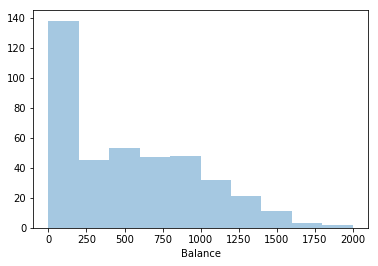

In [20]:
# histogram of dependent variable balance
sns.distplot(data["Balance"], kde=False);

Es ist eine rechtsschiefe Verteilung der Zielvariable Balance zu erkennen. Viel Wahrscheinlichkeitsmasse liegt im bin von 0 bis ca. 200. Die Wahrscheinlichkeitsmasse nimmt ab ca. 900 ab.

In [21]:
# get top 10 samples sorted by balance
data.nlargest(10, 'Balance')

,Balance,Income,Limit,Rating,Cards,Age,Education,IsMarried,IsStudent,IsMale,IsAsian,IsCaucasian,IsAfricanAmerican
323,1999,182.728,13913,982,4,98,17,1,0,1,0,1,0
28,1809,186.634,13414,949,2,41,14,1,0,0,0,0,1
85,1779,152.298,12066,828,4,41,12,1,0,0,1,0,0
191,1687,124.290,9560,701,3,52,17,0,1,0,1,0,0
293,1677,140.672,11200,817,7,46,9,1,0,1,0,0,1
139,1597,107.841,10384,728,3,87,7,0,0,1,0,0,1
102,1587,68.713,7582,531,2,56,16,0,1,1,0,1,0
174,1573,121.834,10673,750,3,54,16,0,0,1,0,0,1
222,1549,33.437,6207,451,4,44,9,0,1,1,0,1,0
184,1448,158.889,11589,805,1,62,17,1,0,0,0,1,0


Eine erste (grobe) Analyse der 10 Personen mit der höchsten Balance lässt keine Aussage über den Einfluss der Ethnizität auf Balance treffen. Limit und Rating scheinen hoch zu sein. Dies wird im weiteren jedoch genauer anhand einer Korrelationsanalyse untersucht. Zudem scheinen die Personen mittleren Alters aufwärts zu sein und tendenziell keine Studenten zu sein.

In [22]:
# get 10 samples with lowest balance
data.nsmallest(10, 'Balance')

,Balance,Income,Limit,Rating,Cards,Age,Education,IsMarried,IsStudent,IsMale,IsAsian,IsCaucasian,IsAfricanAmerican
11,0,15.045,1311,138,3,64,16,0,0,1,0,1,0
15,0,20.089,2525,200,3,57,15,1,0,0,0,0,1
16,0,53.598,3714,286,3,73,17,1,0,0,0,0,1
22,0,20.103,2631,213,3,61,10,1,0,1,0,0,1
24,0,10.742,1757,156,3,57,15,0,0,0,0,1,0
31,0,28.941,2733,210,5,43,16,1,0,1,1,0,0
33,0,31.367,1829,162,4,30,10,1,0,1,0,1,0
34,0,20.150,2646,199,2,25,14,1,0,0,1,0,0
48,0,44.522,2252,205,6,72,15,1,0,1,1,0,0
54,0,15.333,1499,138,2,47,9,1,0,0,1,0,0


Eine erste (grobe) Analyse der 10 Personen mit der geringsten Balance lässt auch keine Aussage über den Einfluss der Ethnizität auf Balance treffen. Auffällig ist, dass keine Studenten unter dieser Personengruppe sind. Das Rating ist in dieser Personengruppe geringer als bei den 10 Personen mit der höchsten Balance. Das Einkommen ist deutlich geringer und das Rating auch. 

Für eine fundierte Aussage reicht es jedoch nicht aus, sich die Personengruppen mit der höchsten und niedrigsten Balance anzuschauen. Im Folgenden wird daher der Einfluss der einzelnen Variablen auf Balance analysiert.

### b) Datensatz teilen
Separieren Sie den Datensatz in 80%-20% für Training und Testdatensatz. Was müssen Sie hier beachten?

In [30]:
# split into dependent y and independent X variables
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

In [31]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Es muss beachtet werden, dass die Daten geshuffelt und dann separiert werden, sodass die Daten iid sind und beispielsweise keine unterschiedliche Varianz o.ä. in den zwei Splits vorhanden ist. Insbesondere sollten Testdaten und Trainingsdaten repräsentativ sein. Die Testdaten werden nur am Ende zur Bewertung eines Modells verwendet, nicht zur Training oder Parametertuning.


### c) OLS mit allen Variablen und ohne Limit
Erstellen Sie aus der Variable Ethnicity drei binäre Variablen Ethnicity_Caucasian, Ethnicity_Asian und Ethnicity_African. Führen Sie eine lineare Regression mit OLS als Schätzer mit diesen Variablen und allen anderen Variablen (außer Limit) durch. Berechnen Sie Root Mean Square Error (RMSE) zwischen der Vorhersage und den wahren Werten im Test-Datensatz. Beschreiben Sie Ihre Ergebnisse.

Binäre Variablen wurde bereits in Teilaufgabe a) erstellt. Ethinicity_Caucasian entspricht IsCaucasian, Ethnicity_Asian entspricht IsAsian und Ethnicity_African entspricht IsAfricanAmerican. Dies wurde eingeführt, um die Interpretation der Ausprägungen zu vereinfachen.

#### Definieren von Funktionen für lineare Regression mit OLS als Schätzer:

In [32]:
# define function for fitting OLS regression model
def ols_statsmodel(X_train, y_train):
    
    # add intercept
    X_train = sm.add_constant(X_train)
    
    # fit model
    model = sm.OLS(y_train, X_train).fit()
    
    return model

In [33]:
# define function for prediction with OLS regression model
def predict_ols_statsmodel(X_test, model):
    
    # add intercept
    X_test = sm.add_constant(X_test)
    
    # predict
    y_predict = model.predict(X_test)
    
    return y_predict 

In [34]:
# define function to calculate rmse
def calculate_rmse(y_predicted, y_gt):
    rmse = sqrt(mean_squared_error(y_gt, y_predicted))
    return rmse

#### Erstellung der Datasets und Modelle:

In [35]:
# create datasets with different variables

# dataset without variable limit
X_train_withoutLimit = X_train.drop(columns="Limit")
X_test_withoutLimit = X_test.drop(columns="Limit")

# create models
model_allVariables = ols_statsmodel(X_train, y_train)
model_withoutLimit = ols_statsmodel(X_train_withoutLimit, y_train)

/home/carmen/anaconda3/envs/python3_7-SmartDataAnalytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Ergebnisse:

#### Adjusted R-squared

In [36]:
# print adjusted r-squared
print('Adjusted R-squared of model with all variables: ' + str(round(model_allVariables.rsquared_adj, 3)))
print('Adjusted R-squared of model without limit: ' + str(round(model_withoutLimit.rsquared_adj, 3)))

Adjusted R-squared of model with all variables: 0.954
Adjusted R-squared of model without limit: 0.95


Zunächst einmal werden die Adjusted R-squared verglichen, da die um die Anzahl der verwendeten exogenen Variablen bereinigt sind. Das Modell mit allen Variablen schneidet mit einem Adjusted R-squared von 0,954 ein wenig besser ab als das ohne Limit mit 0,95.

#### Signifikanz der Koeffizienten

In [37]:
# creating table of p-values
pValues = pd.DataFrame({"With all variables": model_allVariables.pvalues, "Without limit": model_withoutLimit.pvalues})
print('Coefficients of models: ')
display(pValues.round(3))

Coefficients of models: 


,With all variables,Without limit
Age,0.081,0.103
Cards,0.000,0.336
Education,0.554,0.855
Income,0.000,0.000
IsAfricanAmerican,0.000,0.000
IsAsian,0.000,0.000
IsCaucasian,0.000,0.000
IsMale,0.275,0.282
IsMarried,0.606,0.327
IsStudent,0.000,0.000


Nun werden die Koeffizienten untersucht. Die p-Werte zeigen, dass bei dem Modell mit allen Variablen Education, IsMale und IsMarried bei einem Signifikanzniveau von 0,1 nicht signifikant sind. Üblich ist ein Signifikanzniveau von 0,05. Bei letzterem Signifikanzniveau sind auch Rating und Age nicht signifikant.
Bei dem Modell ohne Limit sind Age, Cards, IsMale. IsMarried und Education bereits bei einem Signifikanzniveau 0,1 nicht signifikant sind.

#### Werte der Koeffizienten

In [38]:
# creating table of coefficients
params = pd.DataFrame({"All variables": model_allVariables.params, "Without limit": model_withoutLimit.params})
display(params)

,All variables,Without limit
Age,-0.603695,-0.587846
Cards,19.123826,4.181306
Education,-1.078674,-0.346833
Income,-7.554059,-7.573931
IsAfricanAmerican,-125.589917,-147.741912
IsAsian,-112.294369,-127.308454
IsCaucasian,-114.072764,-133.345157
IsMale,12.493725,12.842603
IsMarried,-6.150365,-12.123810
IsStudent,418.435398,412.661119


Zu erkennen ist, dass sich durch weglassen der Variablen Limit die Werte der Koeffizienten Cards, Education, IsMarried Rating und des Interzepts stark verändern. Auch bei anderen Koeffizienten sind leichte Veränderungen festzuhalten, jedoch werden diese Veränderungen, ohne dass dies statistisch getestet wurde, als weniger wichtig betrachtet. 
Verändungern der Signifikanzen und Werte der Koeffizienten bei weglassen von einzelnen Variablen deuten auf eine Fehlspezifikation bzw. Multikollinearität im Model hin. Die Signifikanzen sind zudem erst bei Beseitigung des starken Multikollinearitätproblems aussagekräftig.

#### RMSE zwischen Vorhersage und Ground Truth der Testdaten

In [39]:
# predict 
predicted_allVariables = predict_ols_statsmodel(X_test, model_allVariables)
predicted_withoutLimit = predict_ols_statsmodel(X_test_withoutLimit, model_withoutLimit)

# print rmse
print('RMSE of model with all variables: ' + str(round(calculate_rmse(predicted_allVariables, y_test), 3)))
print('RMSE of model without limit: ' + str(round(calculate_rmse(predicted_withoutLimit, y_test), 3)))

RMSE of model with all variables: 89.302
RMSE of model without limit: 91.426


Der auf drei Nachkommastellen gerundete RMSE der beiden Modelle unterscheidet um ca. 2 Einheiten von Balance. Das Modell mit allen Variablen schneidet dabei besser ab, was mit der Interpretation des Adjusted R-squared übereinstimmt. 

### d) OLS ohne Variable Ethnicity_Caucasian
Führen Sie die Analyse in 4c) erneut durch, ohne die Variable Ethnicity_Caucasian. Vergleichen Sie diese Ergebnisse mit denen aus 4c).

In [40]:
# create datasets
# drop column IsCaucasian, wo = without
X_train_wo_IsCauc = X_train.drop(columns="IsCaucasian") 
X_test_wo_IsCauc = X_test.drop(columns="IsCaucasian")

# drop column Limit (IsCaucasian is alreade dropped)
X_train_wo_IsCauc_Lim = X_train_wo_IsCauc.drop(columns="Limit") 
X_test_wo_IsCauc_Lim = X_test_wo_IsCauc.drop(columns="Limit")

# create models
model_wo_IsCauc = ols_statsmodel(X_train_wo_IsCauc, y_train)
model_wo_IsCauc_Lim = ols_statsmodel(X_train_wo_IsCauc_Lim, y_train)

/home/carmen/anaconda3/envs/python3_7-SmartDataAnalytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Ergebnisse:

#### Adjusted R-squared

In [160]:
# print adjusted r-squared
print('Adjusted R-sqaured of model with all variables: ' + str(round(model_allVariables.rsquared_adj, 3)))
print('Adjusted R-sqaured of model without limit: ' + str(round(model_withoutLimit.rsquared_adj, 3)))
print('Adjusted R-sqaured of model without isCaucasian: ' + str(round(model_wo_IsCauc.rsquared_adj, 3)))
print('Adjusted R-sqaured of model without limit and isCaucasian: ' + str(round(model_wo_IsCauc_Lim.rsquared_adj, 3)))

Adjusted R-sqaured of model with all variables: 0.954
Adjusted R-sqaured of model without limit: 0.95
Adjusted R-sqaured of model without isCaucasian: 0.954
Adjusted R-sqaured of model without limit and isCaucasian: 0.95


Das Modell mit allen Variablen, sowie das Modell ohne isCaucasian erklären die Streuung der Daten gemessem am adjusted R-squared von 0,954 im Vergleich zu den anderen Modellen mit einem adjusted R-squared von 0,95 besser.

#### Signifikanz der Koeffizienten

In [41]:
# create table of p-values
pValues = pd.DataFrame({"With all variables": model_allVariables.pvalues, "Without limit": model_withoutLimit.pvalues, "Without isCaucasian": model_wo_IsCauc.pvalues, "Without limit and isCaucasian": model_wo_IsCauc_Lim.pvalues})
print('Coefficients of models: ')
display(pValues.round(3))

Coefficients of models: 


,With all variables,Without limit,Without isCaucasian,Without limit and isCaucasian
Age,0.081,0.103,0.081,0.103
Cards,0.000,0.336,0.000,0.336
Education,0.554,0.855,0.554,0.855
Income,0.000,0.000,0.000,0.000
IsAfricanAmerican,0.000,0.000,0.413,0.326
IsAsian,0.000,0.000,0.898,0.677
IsCaucasian,0.000,0.000,NaN,NaN
IsMale,0.275,0.282,0.275,0.282
IsMarried,0.606,0.327,0.606,0.327
IsStudent,0.000,0.000,0.000,0.000


Unabhängig vom Weglassen der Variablen Limit und IsCaucasian sind Income, IsStudent und das Intercept signifikant. IsCaucasian und Limit sind in den Modellen, bei denen sie berücksichtigt wurden jeweils signifikant. Die Signifikanz der Variablen Age, Education, IsMale und IsMarried sind über die Modelle hinweg zwar nicht identisch, aber bei allen Modellen zu einem Signifikanzniveau von 0,05 statistisch nicht signifikant. Interessant ist, dass Cards bei dem Modell mit allen Variablen und dem Modell ohne IsCaucasian scheinbar signifikant ist, bei den anderen Modellen jedoch nicht. Wird IsCaucasian nicht berücksichtigt, werden die anderen Ethnizitäten scheinbar auch nicht mehr signifikant. Das Rating ist bei den Variablen mit Limit nicht signifikant, bei den anderen beiden Modellen hingegen schon.

#### Werte der Koeffizienten

In [43]:
# creating table of coefficients
params = pd.DataFrame({"All variables": model_allVariables.params, "Without limit": model_withoutLimit.params, "Without isCaucasian": model_wo_IsCauc.params, "Without limit and isCaucasian": model_wo_IsCauc_Lim.params})
display(params)

,All variables,Without limit,Without isCaucasian,Without limit and isCaucasian
Age,-0.603695,-0.587846,-0.603695,-0.587846
Cards,19.123826,4.181306,19.123826,4.181306
Education,-1.078674,-0.346833,-1.078674,-0.346833
Income,-7.554059,-7.573931,-7.554059,-7.573931
IsAfricanAmerican,-125.589917,-147.741912,-11.517153,-14.396755
IsAsian,-112.294369,-127.308454,1.778395,6.036703
IsCaucasian,-114.072764,-133.345157,NaN,NaN
IsMale,12.493725,12.842603,12.493725,12.842603
IsMarried,-6.150365,-12.123810,-6.150365,-12.123810
IsStudent,418.435398,412.661119,418.435398,412.661119


Das instabile Verhalten der Koeffizienten über die Modelle hinweg bestätigt, dass Fehlspezifikationen bzw. Multikollinearität im Modell vorhanden sind. Der Einfluss der unterschiedlichen Variablen auf die endogene Variable Balance kann offensichtlich nicht zuverlässig isoliert werden. Dies betrifft insbesondere die Variablen Cards, (Education, hier ist die Veränerung relativ gering), die Ethnizitäten (hier wechselt sogar das Vorzeichen, d.h. ein scheinbar stark negativer Einfluss wird bei IsAisan zu einem positiven Einfluss), IsMarried, Rating und das Interzept. 
Die Multikollinearität müsste genauer untersucht werden und Expertenwissen der Domäne zu Problembehebung einbezogen werden. In Teilaufgabe h) wird erläutert, wieso einfaches Weglassen einer der korrellierten Variablen zu Problemen führen kann.

#### RMSE zwischen Vorhersage und Ground Truth der Testdaten

In [44]:
# predict 
predicted_wo_isCauc = predict_ols_statsmodel(X_test_wo_IsCauc, model_wo_IsCauc)
predicted_wo_isCauc_lim = predict_ols_statsmodel(X_test_wo_IsCauc_Lim, model_wo_IsCauc_Lim)

# print rmse
print('RMSE of model with all variables: ' + str(round(calculate_rmse(predicted_allVariables, y_test), 3)))
print('RMSE of model without limit: ' + str(round(calculate_rmse(predicted_withoutLimit, y_test), 3)))
print('RMSE of model without isCaucasian: ' + str(round(calculate_rmse(predicted_wo_isCauc_lim, y_test), 3)))
print('RMSE of model without limit and isCaucasian: ' + str(round(calculate_rmse(predicted_wo_isCauc_lim, y_test), 3)))

RMSE of model with all variables: 89.302
RMSE of model without limit: 91.426
RMSE of model without isCaucasian: 91.426
RMSE of model without limit and isCaucasian: 91.426


Der RMSE des Modells mit allen Variablen ist um ca. 2 Einheiten von Balance besser als der RMSE der anderen Modelle. Dies bedeutet, dass das Modell mit allen Variablen und damit auch mit Mulikollinearität etwas besser prognostiziert. Jedoch ist nicht untersucht worden, welches bzw. ob eines der anderen Modelle die Multikollinearität sinnvoll bzw. überhaupt bereinigt.

### e) OLS mit unterschiedlichen Variablen
Führen Sie eine lineare Regression (OLS) mit folgenden Variablen durch: 
1. Income, Limit, Age
2. Income, Rating, Age
3. Income, Limit, Rating, Age 

Beschreiben Sie die Koeffizienten, Konfidenzintervalle und Signifikanzniveau. Vergleichen Sie die Ergebnisse.

#### Erstellung der Datasets und Modelle:

In [46]:
# create datasets with different variables
# income (inc), limit (lim), age, rating (rat)
X_train_inc_lim_age = X_train[["Income", "Limit", "Age"]]
X_train_inc_rat_age = X_train[["Income", "Rating", "Age"]]
X_train_inc_lim_rat_age = X_train[["Income", "Rating", "Limit", "Age"]]
X_test_inc_lim_age = X_test[["Income", "Limit", "Age"]]
X_test_inc_rat_age = X_test[["Income", "Rating", "Age"]]
X_test_inc_lim_rat_age = X_test[["Income", "Rating", "Limit", "Age"]]

# create models
model_inc_lim_age = ols_statsmodel(X_train_inc_lim_age, y_train)
model_inc_rat_age = ols_statsmodel(X_train_inc_rat_age, y_train)
model_inc_lim_rat_age = ols_statsmodel(X_train_inc_lim_rat_age, y_train)

#### Ergebnisse:

#### RMSE

In [79]:
# predict 
predicted_inc_lim_age = predict_ols_statsmodel(X_test_inc_lim_age, model_inc_lim_age)
predicted_inc_rat_age = predict_ols_statsmodel(X_test_inc_rat_age, model_inc_rat_age)
predicted_inc_lim_rat_age = predict_ols_statsmodel(X_test_inc_lim_rat_age, model_inc_lim_rat_age)

# print rmse
print('RMSE of model income, limit, age: ' + str(round(calculate_rmse(predicted_inc_lim_age, y_test), 3)))
print('RMSE of model income, rating, age: ' + str(round(calculate_rmse(predicted_inc_rat_age, y_test), 3)))
print('RMSE of model income, limit, rating, age: ' + str(round(calculate_rmse(predicted_inc_lim_rat_age, y_test), 3)))

RMSE of model income, limit, age: 176.084
RMSE of model income, rating, age: 169.234
RMSE of model income, limit, rating, age: 170.44


/home/carmen/anaconda3/envs/python3_7-SmartDataAnalytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Der RMSE ist bei allen drei Modellen deutlich höher als bei den Regressionen der vorherigen Teilaufgaben. Offensichtlich reichen die drei bzw. vier Variablen nicht aus, um Balance vorherzusagen.

#### Werte der Koeffizienten

In [47]:
# creating table of coefficients
params = pd.DataFrame({"Income, Limit, Age": model_inc_lim_age.params, "Income, Rating, Age": model_inc_rat_age.params, "Income, Limit, Rating, Age": model_inc_lim_rat_age.params})
display(params)

,"Income, Limit, Age","Income, Rating, Age","Income, Limit, Rating, Age"
Age,-0.820518,-0.881677,-0.854335
Income,-7.329630,-7.330938,-7.389024
Limit,0.260357,NaN,0.101988
Rating,NaN,3.889386,2.381763
const,-333.273816,-478.148061,-424.587171


Zu erkennen ist, dass sich die Koeffizienten Age und Income über die drei Modelle hinweg relativ wenig verändern. Der Koeffizient Limit wird mehr als verdoppelt von Modell Income, Limit, Age zu Modell Income, Limit, Rating, Age. Auch Rating verändert sich stark, das Interzept ebenso.

##### Konfidenzintervalle

In [70]:
# get confidence intervals
confIn_inc_lim_age = pd.DataFrame(model_inc_lim_age.conf_int(0.05))
confIn_inc_rat_age = pd.DataFrame(model_inc_rat_age.conf_int(0.05))
confIn_inc_lim_rat_age = pd.DataFrame(model_inc_lim_rat_age.conf_int(0.05))

# calculate width of confidence intervals
width_confIn_inc_lim_age = confIn_inc_lim_age[1]-confIn_inc_lim_age[0]
width_confIn_inc_rat_age = confIn_inc_rat_age[1]-confIn_inc_rat_age[0]
width_confIn_inc_lim_rat_age = confIn_inc_lim_rat_age[1]-confIn_inc_lim_rat_age[0]

# rename columns
confIn_inc_lim_age.rename(columns = {0:"Income, Limit, Age: 0.025 ", 1: "Income, Limit, Age: 0.975"}, inplace = True)
confIn_inc_rat_age.rename(columns = {0:"Income, Rating, Age: 0.025", 1: "Income, Rating, Age: 0.975"}, inplace = True)
confIn_inc_lim_rat_age.rename(columns = {0:"Income, Limit, Rating, Age: 0.025", 1: "Income, Limit, Rating, Age: 0.975"}, inplace = True)

# create DataFrame for confIns
confIns = pd.concat([confIn_inc_lim_age, confIn_inc_rat_age, confIn_inc_lim_rat_age], axis=1, join='outer',sort=True)

# display confIns
print("Confidence intervals: ")
display(confIns)

# create DataFrame for widths_confIns
widths_confIns = pd.DataFrame({"Income, Limit, Age":width_confIn_inc_lim_age, "Income, Rating, Age":width_confIn_inc_rat_age, "Income, Limit, Rating, Age":width_confIn_inc_lim_rat_age})

# display widths_confIns
print("Width of confidence intervals: ")
display(widths_confIns)

Confidence intervals: 


,"Income, Limit, Age: 0.025","Income, Limit, Age: 0.975","Income, Rating, Age: 0.025","Income, Rating, Age: 0.975","Income, Limit, Rating, Age: 0.025","Income, Limit, Rating, Age: 0.975"
Age,-1.891570,0.250534,-1.941837,0.178482,-1.909003,0.200333
Income,-8.189807,-6.469453,-8.181468,-6.480407,-8.236621,-6.541427
Limit,0.247789,0.272926,NaN,NaN,0.007311,0.196665
Rating,NaN,NaN,3.703869,4.074903,0.970106,3.793419
const,-403.970593,-262.577038,-551.359133,-404.936989,-512.755269,-336.419073


Width of confidence intervals: 


,"Income, Limit, Age","Income, Rating, Age","Income, Limit, Rating, Age"
Age,2.142104,2.120319,2.109336
Income,1.720354,1.701062,1.695194
Limit,0.025137,NaN,0.189354
Rating,NaN,0.371034,2.823313
const,141.393555,146.422144,176.336196


Die Breite der Konfidenzintervalle Age und Income sind ist über die drei Modelle hin relativ konstant. Allerdings erscheint insbesondere das Intervall von Age relativ breit. Limit scheint im Modell Income, Limit, Age recht präzise geschätzt zu sein. Die Schätzung des Koeffizienten Rating ist im Modell Income, Limit, Rating, Age sehr unpräzise verglichen mit Modell Income, Rating, Age. Die Schätzung der Konstant ist in allen drei Modellen sehr ungenau, Jedoch schwankt dessen Wert über die Modelle hinweg sehr start und ist absolut gesehen sehr viel höher als bei den anderen Koeffizienten. Breite Konfidenzintervalle deuten auch auf Multikorrelation hin.

#### Signifikanz der Koeffizienten

In [54]:
# create table of p-values
pValues_e = pd.DataFrame({"Income, Limit, Age": model_inc_lim_age.pvalues, "Income, Rating, Age": model_inc_rat_age.pvalues, "Income, Limit, Rating, Age": model_inc_lim_rat_age.pvalues})
print('Coefficients of models: ')
display(pValues_e.round(3))

Coefficients of models: 


,"Income, Limit, Age","Income, Rating, Age","Income, Limit, Rating, Age"
Age,0.133,0.103,0.112
Income,0.000,0.000,0.000
Limit,0.000,NaN,0.035
Rating,NaN,0.000,0.001
const,0.000,0.000,0.000


Age ist in keinem der Modelle signifikant. Alle anderen Variablen sind in den drei Modellen zu einem Signifikanzniveau von 0,05 statistisch signifikant.

### f) Korrelation
Was ist Korrelation? Wann benutzt man Pearson Korrelation, Spearman Korrelation und Kendalls Tau? Berechnen Sie Korrelationen zwischen allen Variablen im Trainings-Datensatz. Welche Schlussfolgerung können Sie daraus ziehen?

Anmerkung: 

$*$: Multiplikationszeichen

Auszüge aus Ausschitte aus dem Skript zur Vorlesung Statistik für Fortgeschrittene WS 2018/2019 Lehrstuhl für Analytics and Statistics (Prof. Grothe KIT), S. 58-61)
#### Was ist Korrelation?
Korrelation misst die Stärke und Richtung des Zusammenhangs bzw. der Abhängigkeit zwischen zwei Zufallsvariablen. 
Die Korrelation ist nicht mit Kausalität gleichzusetzen, da zwar ein Zusammenhang zwischen zwei Zufallsvariablen möglich ist, ohne dass diese sich direkt beeinflussen.

#### Pearson Korrelation
Das bekannteste skalare Zusammenhangsmaß zweier Zufallsvariablen X und Y ist der Korrelationskoeffizient
nach Bravais-Pearson:

$$Corr(X,Y) = \rho_{BP} = \dfrac{Cov(X,Y)}{\sqrt{X}*\sqrt{Y}}$$

Er misst die Stärke des linearen Zusammenhangs von X und Y und hängt von den
Randverteilungen von X und Y ab. 
Sein Wertebereich ist $[-1,1]$.

#### Spearman Korrelation
Das Korrelationsmaß Spearmans $\rho_S$ ist unabhängig von der Randverteilung und somit ein Rangkorrelationskoeffizient.
$$\rho_S = \dfrac{Cov(F_X(X), F_Y(Y))}{\sqrt{Var(F_X(X))}*\sqrt{F_Y(Y)}} = \dfrac{Cov(U, V)}{\sqrt{Var(U)}*\sqrt{Var(V)}}$$

$F_Z(Z)$ ist die Verteilungsfunktion der Zufallsvariable $Z$

Als Rangkorrelationskoeffizient ist Spearmans's $\rho_S$ invariant gegenüber streng monoton wachsende Transformationen $\alpha(.)$ und $\beta(.)$ der Ränder: 

$$ \rho_{S,X,Y} = \rho_{S,\alpha(x), \beta(Y)} $$

Auch hier ist der Wertebereich $[-1,1]$, jedoch wird nicht die Stärke des linearen Zusammenhangs zwischen den Zufallsvariablen X und Y, sondern zwischen U und V und somit den monotonen Zusammenhangs zwischen X und Y gemessen.


##### Kendalls $\tau$
Seien X, Y Zufallsvariablen mit gemeinsamer Verteilungsfunktion F X,Y und Copula C.
Mit $(X^∗ , Y^∗ )$ bezeichnen wir eine ”unabhängige Kopie” von $(X,Y)$.
Kendalls $\tau$ ist dann definiert durch:

$$\tau = P((X-X^*)((Y-Y^*))>0)-P((X-X^*)((Y-Y^*))<0)$$

Die erste Wahrscheinlichkeit heißt Konkordanz- die zweite Wahrscheinlichkeit Diskordanzwahrscheinlichkeit. Man kann zeigen, dass

$$ \tau = \dfrac{Cov(sign(X-X^*), sign(Y-Y^*))}{\sqrt{Var(sign(X-X^*))}\sqrt{Var(sign(Y-Y^*))}}$$

mit $$sign(z)= \left\{ \begin{array}{c} 1\quad z>0\\0 \quad   z=0\\-1 \quad   z<0 \end{array} \right.$$

Auch Kendalls $\tau$ ist ein Rangkorrelationskoeffizient.

#### Wann verwendet man was
Rangkorrelationsmaße können auch für ordinalskalierte Daten verwendet werden.
Ein linearer Zusammenhang impliziert einen monotonen Zusammenhang. Umgekehrt gilt dies nicht.
Ein Rangkorrelationsmaß ist zudem robuster gegenüber Ausreißer.

#### Berechnungen und Schlussfolgerung

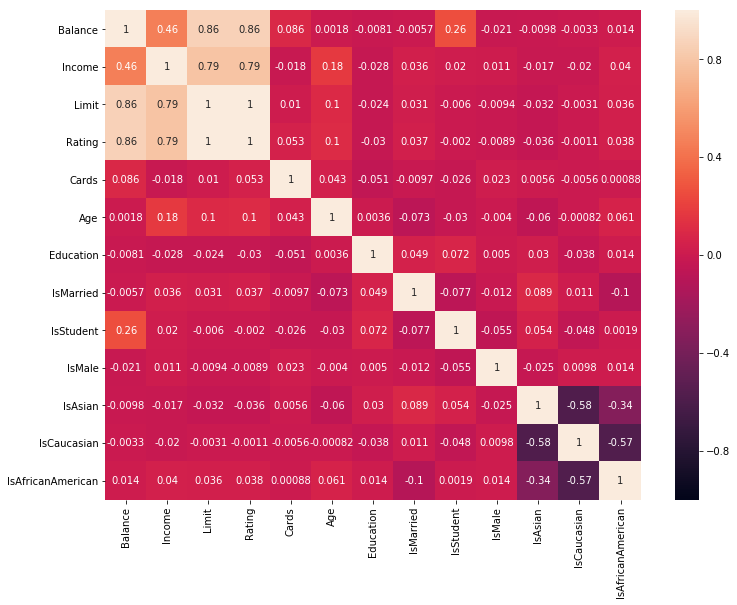

In [56]:
# calculate pearson correlation
corr_pearson = data.corr('pearson')
# set figure size
fig = plt.figure(figsize=(12,9))
# visualize correlation matrix as heatmap
sns.heatmap(corr_pearson,vmin=-1,vmax=1,annot=True)
plt.show()

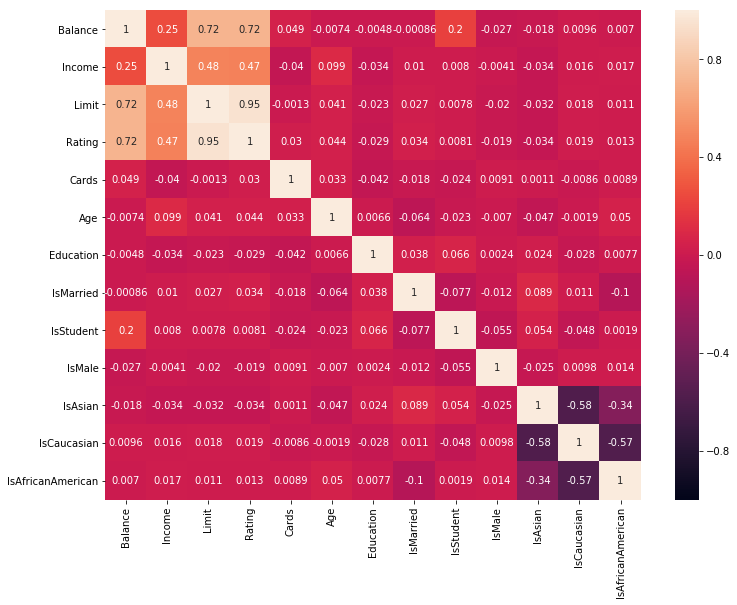

In [60]:
# calculate kendalls correlation
corr_kendall = data.corr('kendall')
# set figure size
fig = plt.figure(figsize=(12,9))
# visualize correlation matrix as heatmap
sns.heatmap(corr_kendall,vmin=-1,vmax=1,annot=True)
plt.show()

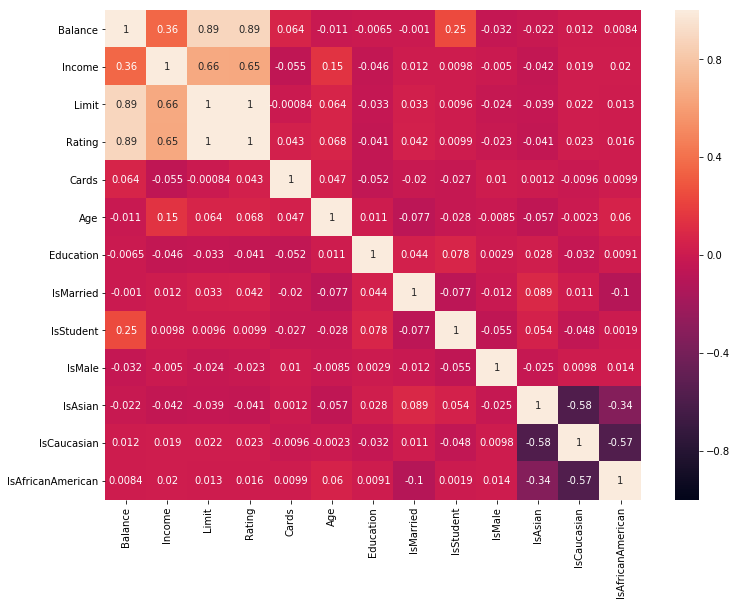

In [62]:
# calculate spearman correlation
corr_spearman = data.corr('spearman')
# set figure size
fig = plt.figure(figsize=(12,9))
# visualize correlation matrix as heatmap
sns.heatmap(corr_spearman,vmin=-1,vmax=1,annot=True)
plt.show()

Bei allen drei Korrelationsmaßen sind die Ethnizitäten negativ miteinander korreliert (corr(isAsian, isCaucasian) = -0,58, corr(isAsian, isAfroAmerican) = -0,34, corr(isCaucasian, isAfroAmerican) = -0,57). Dies ist darauf zurückzuführen, dass jede Person nur einer der drei Ethnizitäten zugeordnet wird. 

Gemessen anhand des Pearson-Korrelationsmaßes sind Balance und Limit (0,85), Balance und Rating (0,86), Income und Limit (0,79) und Income und Rating (0,79) stark positiv korreliert. Auch Balance und Income weisen eine positive Korrelation auf (0,46). Gemessen mit dem Kendall's Tau sind Balance und Limit (0,72), Balance und Rating (0,72), Limit und Rating (0,95) sehr stark miteinander korreliert. Die positive Korrelation zwischen Balance und Income beträgt nur noch 0,25. Income und Limit (0,48), Income und Rating (0,47) sind auch positiv miteinander korreliert. 

Gemessen anhand des Spearman Korrelationsmaßes sind Balance und Limit (0,72), Balance und Rating (0,72), Rating und Limit (0,95) stark positiv miteinander korreliert. Income und Limit (0,48), Rating und Income (0,47) sind auch positiv miteinander korreliert. Auch hier sind Balance und Income mit 0,25 nur noch schwach positiv miteinander korreliert. 

Die Korrelationsmaße zeigen, das starke Multikollinearität vorliegt. Insbesondere Rating und Limit sind beinaher perfekt positiv miteinander korreliert. Das Problem muss für eine präzise Schätzung der Koeffizienten unbedingt behoben werden. Wie in Teilaufgabe h) erläutert, ist dies jedoch nicht trivial.

### g) Random Forest
Führen Sie die Analyse in 4e) mit Random Forest anstatt der linearen Regression durch. Variieren Sie dabei den Parameter random_state mit den Werten {1, 33, 135, 123, 99, 22} und einigen selbst gewählten Werten. Berechnen Sie MSE des Test-Datensatzes. Vergleichen Sie Feature Importance. Welche Schlussfolgerung können Sie daraus ziehen?

In [74]:
# define funcion for random forest
def randomForest(random_state_value, X_train, y_train, X_test, y_test):

    # instantiate model 
    rf = RandomForestRegressor(random_state = random_state_value, n_estimators = 100)

    # train the model on training data
    rf.fit(X_train, y_train)
   
    # Use the forest's predict method on the test data
    y_pred = rf.predict(X_test)

    # calculate the root mean squared error and mse
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    
    # returns the mean accuracy on the given test data and labels.
    score = rf.score(X_test, y_test)
    
    # calculate feature importances
    feature_importances = pd.DataFrame(rf.feature_importances_,
                                      index = X_train.columns,
                                      columns = ['importance']).sort_values('importance', ascending=False) 

    return mse, rmse, score, feature_importances

In [78]:
# list with random states
random_states = [1, 2, 22, 33, 99, 123, 135, 200]

# for loop over random states
for random_state in random_states:
    
    # fit models and get mean accuray, mse, rmse and feature importances of each model
    mse_inc_lim_age, rmse_inc_lim_age, score_inc_lim_age, feature_importances_inc_lim_age = randomForest(random_state, 
                                                                                        X_train_inc_lim_age, y_train, 
                                                                                        X_test_inc_lim_age , y_test)
    mse_inc_rat_age ,rmse_inc_rat_age, score_inc_rat_age, feature_importances_inc_rat_age = randomForest(random_state, 
                                                                                        X_train_inc_rat_age, y_train, 
                                                                                        X_test_inc_rat_age, y_test)    
    mse_inc_rat_age, rmse_inc_lim_rat_age, score_inc_lim_rat_age, feature_importances_inc_lim_rat_age = randomForest(random_state, 
                                                                                                    X_train_inc_lim_rat_age, y_train, 
                                                                                                    X_test_inc_lim_rat_age, y_test)
    # create DataFrame out of Series for nice graphics of metrics mean accuracy and rmse
    rf_metrics_inc_lim_age = pd.Series([round(mse_inc_lim_age, 3), round(rmse_inc_lim_age, 3), round(score_inc_lim_age, 3)], index = ["mse", "rmse", "mean accuracy"])
    rf_metrics_inc_rat_age = pd.Series([round(mse_inc_rat_age, 3), round(rmse_inc_rat_age, 3), round(score_inc_rat_age, 3)], index = ["mse", "rmse", "mean accuracy"])
    rf_metrics_inc_lim_rat_age = pd.Series([round(mse_inc_rat_age, 3), round(rmse_inc_lim_rat_age, 3), round(score_inc_lim_rat_age, 3)], 
                                           index = ["mse", "rmse", "mean accuracy"])
    rfs_metrics = pd.DataFrame({"income, limit, age" : rf_metrics_inc_lim_age, 
                                "income, rate, age" : rf_metrics_inc_rat_age, 
                                "income, limit, rate, age" : rf_metrics_inc_lim_rat_age}, 
                               index = ["mse", "rmse", "mean accuracy"])
    
    # display metrics
    print("Random state = " + str(random_state))
    display(rfs_metrics)
    
    # round importances
    feature_importances_inc_lim_age = round(feature_importances_inc_lim_age, 3)
    feature_importances_inc_rat_age = round(feature_importances_inc_rat_age, 3)
    feature_importances_inc_lim_rat_age = round(feature_importances_inc_lim_rat_age, 3)
    
    #rename columns of feature importances
    feature_importances_inc_lim_age.rename(columns = {"importance":"importance: income, limit, age"}, inplace = True)
    feature_importances_inc_rat_age.rename(columns = {"importance":"importance: income, rate, age"}, inplace = True)
    feature_importances_inc_lim_rat_age.rename(columns = {"importance":"importance: income, limit, rate, age"}, inplace = True)
    
    # create DataFrame out of Series for nice graphics feature importances
    feature_importances = pd.concat([feature_importances_inc_lim_age, 
                                     feature_importances_inc_rat_age, 
                                     feature_importances_inc_lim_rat_age], 
                                    axis=1, join='outer', sort=True)
    
    # display feature importances
    display(feature_importances)
    
    # empty line for nicer representation
    print("\n")

    
    

Random state = 1


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,31548.046,30575.729,30575.729
rmse,177.618,180.162,174.859
mean accuracy,0.811,0.806,0.817


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.021,0.022,0.016
Income,0.100,0.107,0.091
Limit,0.879,NaN,0.424
Rating,NaN,0.871,0.469




Random state = 2


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,32740.911,32460.875,32460.875
rmse,180.944,183.239,180.169
mean accuracy,0.804,0.799,0.806


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.020,0.021,0.017
Income,0.099,0.109,0.091
Limit,0.880,NaN,0.371
Rating,NaN,0.870,0.521




Random state = 22


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,32123.418,33434.847,33434.847
rmse,179.230,185.505,182.852
mean accuracy,0.808,0.794,0.800


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.021,0.022,0.017
Income,0.101,0.110,0.092
Limit,0.878,NaN,0.401
Rating,NaN,0.868,0.489




Random state = 33


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,32709.194,33056.590,33056.590
rmse,180.857,182.469,181.815
mean accuracy,0.804,0.801,0.802


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.020,0.022,0.016
Income,0.099,0.109,0.091
Limit,0.881,NaN,0.385
Rating,NaN,0.870,0.508




Random state = 99


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,32167.645,32503.452,32503.452
rmse,179.353,182.270,180.287
mean accuracy,0.807,0.801,0.805


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.022,0.022,0.018
Income,0.097,0.105,0.087
Limit,0.881,NaN,0.473
Rating,NaN,0.873,0.423




Random state = 123


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,33087.899,31992.497,31992.497
rmse,181.901,183.591,178.864
mean accuracy,0.802,0.798,0.809


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.020,0.022,0.017
Income,0.101,0.107,0.092
Limit,0.879,NaN,0.390
Rating,NaN,0.872,0.500




Random state = 135


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,32037.358,31747.929,31747.929
rmse,178.990,184.834,178.179
mean accuracy,0.808,0.796,0.810


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.020,0.022,0.017
Income,0.100,0.110,0.092
Limit,0.879,NaN,0.434
Rating,NaN,0.868,0.457




Random state = 200


,"income, limit, age","income, rate, age","income, limit, rate, age"
mse,32842.599,31630.692,31630.692
rmse,181.225,183.486,177.850
mean accuracy,0.803,0.798,0.811


,"importance: income, limit, age","importance: income, rate, age","importance: income, limit, rate, age"
Age,0.020,0.021,0.017
Income,0.100,0.110,0.092
Limit,0.879,NaN,0.391
Rating,NaN,0.869,0.501


Zu erkennen ist, dass der RMSE der Random Forests etwas höher als bei den entsprechenden Regressionen liegt. Die Regression scheint somit etwas geeigneter für das konkrete Problem zu sein. Ggf. können die Ergebnisse des Random Forest jedoch noch durch Parametertuning verbessert werden. 

Auffällig ist, dass das Modell Income, Rate, Age gemessen am RMSE und der Mean Accuracy bei den Random Forests durchweg etwas schlechter als die beiden anderen Modelle abschneidet. Die RMSE unterscheiden sich zwar über die Modelle hinweg, jedoch sehr geringfügig. Daraus ist zu schließen, dass die Multikollinearität sich kaum auf die Prognosefähigkeit auswirkt. Jedoch ist klar zu erkennen, dass bei den Modellen, bei denen entweder Limit oder Rating verwendet werden, die Freature Importance jeweils sehr hoch ist. Werden beide verwendet, so ist offensichtlich der Einfluss der einzelnen Variablen auf Balance schwer zu isolieren. Dies ist auf die starke Korrlation zwischen den beiden Variablen zurückzuführen. Sie liefern quasi die gleiche Information, sodass sich die Wichtigkeit auf die beiden Variablen "verteilt" und beide weniger wichtig erscheinen. 

Age scheint einen deutlich geringeren Informationsgehalt bzgl. der Balance zu haben, Income ein wenig mehr, doch deutlich weniger als Limit oder Rating. Zu erkennen ist, dass sich die Importance von Age und Income über alle Modelle hin wenig verändert.

### h) Multikollinearität
Was ist Multikollinearität? Was sind ihre möglichen Ursachen und Auswirkungen? Wie kann man sie erkennen? Welche Maßnahmen gibt es, wenn Variablen in den Daten kollinear sind?

Multikollinearität liegt vor, wenn zwei oder mehr erklärende Variablen hoch untereinander korreliert sind. Mit zunehmender Multikollinearität wird das Verfahren um die Regressionsparameter zu schätzen instabil und die Interpretation des Modells uneindeutig. Zwar ist der Schätzer im Falle hoher Multikollinearität immer noch BLU (best linear unbiased), jedoch sind die Koeffizienten sehr ungenau geschätzt und das Konfindenzinterval zwar gültig, jedoch sehr breit. Dies ist darauf zurückzuführen, dass der Einfluss der einzelnen Variablen schlecht isoliert werden kann.
Instabile Koeffizienten können u.a. folgende Konsequenzen haben:
- Die Koeffizienten sind anscheinend nicht signifikant, selbst wenn eine signifikante Beziehung zwischen dem Prädiktor und der Antwortvariablen besteht. Erkennbar wird dies z.B. durch ein hohes Bestimmtheitsmaß (z.B. $R²$) zusammen mit wenig Signifikanz für die Regressionsparameter
- Die Koeffizienten für stark korrelierte Prädiktoren variieren erheblich von Stichprobe zu Stichprobe.
- Das Entfernen von stark korrelierten Termen aus dem Modell hat schwerwiegende Auswirkungen auf die geschätzten Koeffizienten der anderen stark korrelierten Terme. Die Koeffizienten der stark korrelierten Terme können sogar ein falsches Vorzeichen aufweisen.

Zudem kann man Multikollinearität anhand der paarweise Korrelation zwischen den Regressoren (größer 0,7 oder 0,8) Multikollinearität erkennen. Eine weitere Möglichkeit sind Hilfsregressionen, bei denen die erklärenden Variablen aufeinander regressiert werden. Je höher das $R²$ dieser Hilsregression, desto größer das Multikollinearitätsproblem.

Perfekte Mulikollinearität (exakte lineare Beziehung zwischen Regressoren) führt dazu, dass die Durchführung der linearen Regressionsalanyse unmöglich wird.

Ursache perfekter Multikollinearität sind beispielsweise falsch verwendete Dummyvariablen, also z.B. eine Variable isStudent und eine isNotStudent. Ursachen für beinahe Mutlikollinearität sind gemeinsame Trends oder zu viele erklärende Variablen, die fast dasselbe messen.

Probleme: Insbesondere bei der Schätzung des Einflusses der erklärenden Variable auf die abhängige Variable liegt ein Problem vor. 

Maßnahmen:
- Transformation der Variablen: beispielsweise Bildung erster Differenzen bei trendbehafteten Zeitreihen
- Variable weglassen (kann gefährlich werden: wenn beispielsweise Raucher ihr Handy in der Hosentasche aufbewahren, da eine andere Taschen der Kleidung mit der Zigarrettenschachtel belegt ist. Würde man nun die Variable istRaucher weglassen und bestimmen, ob und welchen Zusammenhang das Handy in der Hosentasche auf das Krebsrisiko hat, könnten schnell falsche Schlüsse gezogen werden)
- Verwenden der Hauptkompontenanalyse zur Verringerung der Anzahl von exogenen Variablen. Dies wirkt sich jedoch negativ auf die Interpretierbarkeit des Modells aus.


(https://www.uibk.ac.at/econometrics/einf/kap08la.pdf, https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/, https://support.minitab.com/de-de/minitab/18/help-and-how-to/modeling-statistics/regression/supporting-topics/model-assumptions/multicollinearity-in-regression/)
